# PyTorch modelling and graph-building of the WWD model

Approximate run duration: 1 subject from HCP(tr= 0.75 and length of BOLD =1200) fitting without or with gains with 20 epoches: 
# *   15-20 mins*

In this notebook, we perform the modelling and graph-building for the Wong-Wang neuronal mass model in determining network activity. 

This large-scale dynamic mean field model (DMF) approximates the average ensemble  behavior, instead of considering the detailed interactions between individual neurons. This allow us varying the parameters and, furthermore, to greatly  simplify the system of stochastic differential equations by expressing it  in terms of the first and second-order statistical moments, means and covariances, of network activity. In the following we present the details of the model and its simplified versions.  

This file performs the modelling and graph-building for the Wong-Wang neuronal mass model
in determining network activity. 

## WWD 

To describe mesoscopic population activity at each region in the whole-brain network, we use the equations derived in \citet{deco2013restingstate,deco2014local}, which are variously termed in the literature the `Dynamic Mean Field', `Wong-Wang-Deco' (WWD), and `Reduced Wong-Wang' (RWW) model. Here we use the latter appellation. Specifically, we use the \textit{two-state} or \textit{E-I} version of the RWW equations. In this model, each brain network node consists of two neural masses: one describing the average behavior of an excitatory neural subpopulation, and the other the behaviour of an inhibitory neural subpopulation. Activity in each of these subpopulations at a given brain network node $i \in [ 1... N]$ is described by the unitless state variables $E_i$ / $I_i$ representing synaptic activity levels, as well as auxiliary variables $R_i^E$ / $R_i^I$ (population firing rates) and $I_i^E$ / $I_i^I$ (synaptic currents). These evolve according to the following coupled nonlinear stochastic differential equations:

\begin{align}
 \dot{E}_i =& -\frac{1}{\tau_E} E_i \
              +\big( 1-E_i \big) \
              \gamma R^E_i 
              + \sigma v_i              \tag{4} \\
 \dot{I}_i =& -\frac{1}{\tau_I} I_i \
              +R^I_i \ 
              + \sigma v_i              \tag{5}
\end{align}



where $\tau_E$ and $\tau_I$ are the decay times of the excitatory and inhibitory synapses, respectively, $\gamma$ is a kinetic parameter, and $\sigma v_i$ is an uncorrelated Gaussian noise process of mean 0 and standard deviation $\sigma$. The principal input to $E_i$ and $I_i$ are the population firing rates $R^E_i$ and $R^I_i$, which are expressed as sigmoidal functions of the input currents $I^E_i$ and $I^I_i$ as follows:

\begin{align}
  R^E_i =& \frac{a_E  I^E_i -b_E \
            }{1 -e^{-d_E \big(a_E I^E_i -b_E \big)}}     \tag{6} \\
  R^I_i =& \frac{a_I I^I_i-b_I   \ 
            }{1 -e^{-d_I \big(a_I I^I_i-b_I \big)}}      \tag{7} 
\end{align}


Parameters $a_E$, $a_I$, $b_E$, $b_I$, $d_E$ and $d_I$ govern the specifics of the conversion of input currents to population firing rates (see Table 1 for further info). The two input currents are computed as follows:

\begin{align}
  I^E_i =&    \ 
            W_E I_0 \ 
            + w_+ J_{nmda} E_i \
            + G J_{nmda} \sum_j L_{ij} E_j \ 
            -J_i I_i \ 
            +I_{ext}                                \tag{8} \\
  I^I_i =&    \
            W_I I_0 \ 
            +J_{nmda} E_i \ 
            -I_i \ 
            +\lambda G  J_{nmda} \sum_j L_{ij} E_j                                 \tag{9} 
\end{align}


where $I_{ext}$ encodes external stimulation, and is set to 0 when simulating resting state activity. $I_0$ represents a constant external input, scaled by parameters $W_E$ and $W_I$ for the excitatory and inhibitory populations, respectively. $L_{ij}$ denotes the elements of the connectivity Laplacian, defined as $L=D-C$, where $C$ is the (log-transformed and unit-normalized) tractography-derived connectivity (adjacency) matrix that gives the connection strength between network nodes $i$ and $j$, and $D$ is the diagonal matrix of node degree (i.e. the row sums of $C$). The term $\sum_j L_{ij} \: E_j$ thus encodes the total summed input to node $i$ from all other $j$ nodes in the network. The parameter $\lambda$ allows the removal of long-range feedforward inhibition \citep{deco2014local} when set to 0, as is done here. Parameters $J_{nmda}$ and $J_i$ represent the value of the excitatory synaptic coupling and the local feedback inhibitory synaptic coupling, respectively, while parameters $w_+$ and $G$ scale the local and long-range excitatory couplings, respectively.

An interesting and important feature of the RWW model is that it is one of the few widely used neural mass models that is directly derived, via mean field reduction techniques, from a  `lower level' mathematical description of individual (conductance-based leaky integrate-and-fire) neurons. This was first done for the one-state (slow excitatory population only) model by \cite{deco2013restingstate}, and subsequently for the two-state (excitatory and inhibitory population) model in \cite{deco2014local}, which give the equations used here. This two-state RWW model is similar in many respects to the classic equations of \citet{wilson1972excitatory}, who famously introduced the notion of predator/prey-like excitatory/inhibitory population interactions as a generic description of cortical tissue.
In both \citet{deco2013restingstate} and \citet{deco2014local}, the authors also derive further reductions, arriving finally at a linearized algebraic expression for neural population covariance structure, which is interesting but shall not be considered further in the present paper. 

In addition to deriving and introducing the two-state RWW model, \citet{deco2014local} also introduced an iterative algorithm designed to keep the synaptic current terms within a specific biologically-motivated range. Here we employ a different but related constraint: we squash the input current variables in Equations 8 and 9 using a \texttt{tanh} function. This is a more mathematically well-behaved way of specifying variable limits than explicit constraints or iterative algorithms (it is differentiable, for example), and we have found improves model fit performance considerably. 

The notation above follows closely that of \cite{deco2014local}. In this paper we also adopt the following alternative notation for several commonly discussed terms: 

\begin{align}
g_{EI} =& J_{nmda}          \tag{10} \\ 
\nonumber \\
g_{IE} =& J_i               \tag{11} \\  
\nonumber \\
g_{EE}/g_{EI}  =& w_+       \tag{12} \\ 
\nonumber \\
g/g_{EI}  =& G              \tag{13} 
\end{align}



which define the within-node excitatory-to-inhibitory, inhibitory-to-excitatory, and excitatory-to-excitatory synaptic gains ($g_{EI}$, $g_{IE}$, $g_{EE}$, respectively), as well as the long-range global coupling  $g$. This new notation is convenient because it is more uniform and follows general conventions in relation to connectivity weight subscripts. We will eventually fit these four parameters by comparing the results of simulations of the model to empirical data. Naming the strengths of the local and global couplings between neural masses in a simple and explicit way will allow us to interpret the fitted parameters more straightforwardly.


\paragraph{Haemodynamics.}
The forward model function $g(\textbf{x})$ models the transformation of the state variables of the neural mass model into a quantity that can be compared to the experimental BOLD signal obtained by fMRI. Following \cite{deco2014local}, for this we use here the Balloon-Windkessel model \citep{friston2000nonlinear}, which captures much of the known biophysics of BOLD signal generation.


% removed: This can be used in modelling the transient aspects of the BOLD signal using the output function described \citep{friston2000nonlinear}. 
In the  Balloon-Windkessel model, the vascular bed in a small volume of tissue is modelled as an expandable venous compartment. The output of the capillary bed (volume flow rate into the tissue $f_{i}(t)$, in units of ml/s) is specified to be a function of time, and drives the system. Blood volume changes happen primarily in the venous compartment. This input-state-output model can use the BOLD signal equation with a nonlinear function of normalized venous volume $v$, normalized total deoxyhemoglobin content $q$, and resting net oxygen extraction fraction by the capillary bed $E_{i}$. We can then define the rates at which each variable changes as the Balloon model expands and contracts, using the following equations:

%. The equations are given by

\begin{align}
  \dot{q}_i =& \frac{1}{\rho \tau_0} \
                f_i(1-(1-\rho)^{\frac{1}{f_i}})
               -\frac{1}{\tau_0}\
               (q_iv_i^{\frac{1}{\alpha}-1})      \tag{14}  \\
  \dot{v}_t =& \frac{1}{\tau_0}\
                (f_i -v_i^{\frac{1}{\alpha}})   \tag{15}  \\
  \dot{f}_i =& x_i                              \tag{16}  \\
  \dot{x}_i =& E_i -\frac{1}{\tau_s}x_i \ 
                   -\frac{1}{\tau_f}(f_i-1)     \tag{17}
\end{align}



with rate constant $\rho$, transit time $\tau_{0}$, stiffness parameter $\alpha$, signal decay $\tau_{s}$, and autoregulation $\tau_{f}$ as constants for the model (see Table 1 for nominal values). $\dot{q}_i$ is defined using flow rate multiplied by the concentration, representing the difference between the delivery of deoxyhemoglobin into the venous compartment and the deoxyhemoglobin expelled with the extraction function $E_{i}$ (defined as $1 - (1 - \rho)^{1/f}$) across transit time $\tau_{0}$. The rate of change of the volume $\dot{v}_t$ is defined as the difference between inflow $f_{in}$ and outflow $f_{out}$ (or $v_i^{\frac{1}{\alpha}-1}$) divided by the transit time $\tau_{0}$. Differentiating $\dot{f}$ one more time, we obtain $\dot{x}$, which can model the flow between different steps of the model. The BOLD signal is then given by

\begin{align}
y =  V_0\
    \left(\
     k_1\left(1-q_1\right) \
    +k_2\left(1-\frac{q}{v}\right) \
    +k_3\left(1-v\right) \
    \right)                             \tag{18}
\end{align}

where $V_0$, $k_i, \;i=1,2,3$ are constant coefficients. 

In [1]:
"""from google.colab import drive
drive.mount('/content/drive/')"""


Mounted at /content/drive/


In [2]:
"""cd /content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/wwd-model-fitting/final/"""

/content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/wwd-model-fitting/final


In [3]:
import sys
sys.path.append('code/')

In [5]:
from rww_pytorch_model import ParamsJR
from rww_pytorch_model import RNNWWD
from rww_pytorch_model import Model_fitting
import matplotlib.pyplot as plt # for plotting
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import seaborn as sns # for plotting 
import time # for timer

## Setup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


epoch:  0 -11.34034
epoch:  0 0.1867547908279359 cos_sim:  -0.0008165644689778518
epoch:  1 -12.943409
epoch:  1 0.5103955968638059 cos_sim:  -0.0007418564646152761
epoch:  2 -14.065183
epoch:  2 0.45984376223591644 cos_sim:  -0.0008690004103601113
epoch:  3 -14.972257
epoch:  3 0.5813984440739195 cos_sim:  -0.0004922853277597512
epoch:  4 -15.799814
epoch:  4 0.6215538478887723 cos_sim:  -0.0012752751605825746
epoch:  5 -16.3585
epoch:  5 0.575016215452602 cos_sim:  -0.00016690953895199726
epoch:  6 -16.875488
epoch:  6 0.591191160196644 cos_sim:  -0.0009729484800214381
epoch:  7 -17.384619
epoch:  7 0.6881539240906146 cos_sim:  -0.0004994268237437846
epoch:  8 -17.895897
epoch:  8 0.6600123055614249 cos_sim:  0.0001722704248658097
epoch:  9 -18.277851
epoch:  9 0.6157876924004331 cos_sim:  -0.001000578311663255
epoch:  10 -18.588602
epoch:  10 0.6798972389371292 cos_sim:  -0.0005821836783855887
epoch:  11 -18.946135
epoch:  11 0.6733215866190124 cos_sim:  -0.0003752725097996935
epoch

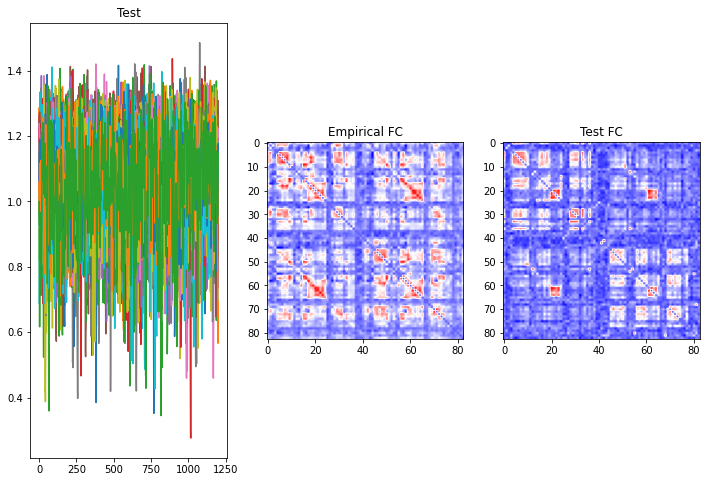

running time is  857.5366554260254 's


In [16]:
start_time = time.time()

sc_file = '../data/HCP/weights.txt'
ts_file = '../data/HCP/154532_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
base_dir = '../data/HCP/'

start_time = time.time()


sc = np.loadtxt(sc_file)
sc = sc -np.diag(np.diag(sc))
sc = 0.5*(sc.T+sc)
sc = np.log1p(sc)/np.linalg.norm(np.log1p(sc))

dist = np.nan_to_num(1/sc)
dist[dist> 200] = 0
ts_pd = pd.read_pickle(ts_file)
ts = ts_pd.values
ts = ts/np.max(ts)
#ts = np.ones((100, 83))
fc_emp = np.corrcoef(ts.T)




node_size = 83
output_size = 83
num_epoches = 20
batch_size =20
step_size = .05
input_size = 2
tr = .75

## call WWD module
par = ParamsJR("WWD", g = [80,.2], g_EE= [0.5, 5], g_IE= [0.5, 5], \
                    g_EI= [0.16963709468378746, 10], I_0=[0.39410256410256406, 10],\
                    std_in=[0.02, 0],  mu = [2.5, 5])



"""par = ParamsJR("WWD", g = [20, 0], g_EE= [3.393939393939394, 0], g_IE= [10.260801579764808, 0], \
                    g_EI= [0.3290554714188569, 0], I_0= [0.39410256410256406, 0], tau_E =[0.05, 0], tau_I =[ 0.01, 0], gamma_E= [0.641, 0], gamma_I = [1, 0],\
                    std_in=[0.05, 0],  mu = [5.5, 0])# Get the WWD model module for forward in a batch.""" 
"""par = ParamsJR("WWD", g = [2, 0], g_EE= [3.5, 0], g_IE= [2.5, 0], \
                    g_EI= [3.75, 0], I_0= [0.382, 0], tau_E =[ 0.01, 0], tau_I =[ 0.02, 0], gamma_E= [0.641, 0], gamma_I = [1, 0],\
                    std_in=[0.01, 0],  mu = [5.5, 0])# Get the WWD model module for forward in a batch."""
model = RNNWWD(input_size, node_size, batch_size, step_size, tr, sc, dist, True,  par)





data_mean = [ts.T]*num_epoches
data_mean =np.array(data_mean)
# call model fit method
F = Model_fitting(model, data_mean, num_epoches, 1)

# fit data(train)

output_train = F.train()

X0 = 0.45 * np.random.uniform(0, 1, (node_size, 6)) + np.array(
            [0, 0, 0, 1.0, 1.0, 1.0])
hE0 = np.random.uniform(0, 5, (node_size, 500))
base_batch_num = 20
output_test = F.test(X0, hE0, base_batch_num)
#output_test = F.test(120)
fc_test = np.corrcoef(F.output_sim.bold_test)

fig, ax = plt.subplots(1,3, figsize=(12,8))
ax[1].imshow(fc_emp-np.diag(np.diag(fc_emp)), cmap='bwr')
ax[1].set_title('Empirical FC')
ax[0].plot(F.output_sim.bold_test.T)
ax[0].set_title('Test')
ax[2].imshow(fc_test-np.diag(np.diag(fc_test)), cmap='bwr')
ax[2].set_title('Test FC')
plt.show()

end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))
